In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,valid_data,valid_label = pickle.load(f)
    return train_data,train_label,valid_data,valid_label

# data_path = 'adress_512.pkl'
data_path = 'adress_transformer.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,valid_data,valid_label = load_data(data_path)

# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(train_y.shape[0]).astype(float);
train_y = torch.from_numpy(train_y)


# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(CTX),train_y.to(CTX)) # create your datset

 # create your dataloader


In [2]:
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(val_y.shape[0]).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data

val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
# val_size = 297
# train_size = train_x.size(0) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 2379
#Length of Validation Data : 297

#load the train and validation into batches.
train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import recall_score as recall
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out, _softmax= self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out, _softmax = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(_softmax, labels.to(torch.int64).cuda())           # Calculate accuracy
        
        valid_conf = confusion(np.argmax(_softmax.cpu(),1),labels.cpu())
#         valid_conf = 8008
#         print(np.argmax(out.cpu(),1))
#         print(labels.cpu())
        print ('Valid Confusion Matrix:["cc","cd"]')
        print(valid_conf)
        print ('Recall')
        print(recall(np.argmax(_softmax.cpu(),1),labels.cpu(),average='macro'))
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.8f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
#         print (result['valid_conf'])

In [5]:
#change nn.sequential to take dict to make more readable 

class parallel_all_you_want(ImageClassificationBase):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 40-->512--->40 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock2 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 8 logits 
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array 
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2+40 == 1064 input features --> 8 output emotions 
        self.fc1_linear = nn.Linear(512*2+40,num_emotions) 
        
        ### Softmax layer for the 8 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
         
        ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
        x_maxpool = self.transformer_maxpool(x)

        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
        
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        
        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)  

        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax  

In [6]:
# defining the model
model = parallel_all_you_want(num_emotions = 2)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function

criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

parallel_all_you_want(
  (transformer_maxpool): MaxPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0, dilation=1, ceil_mode=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=512, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=512, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=Tru

In [7]:
# !pip install torch-summary
# from torchsummary import summary
# # summary(model, (1, 40, 282))

In [8]:
# input=torch.randn(50,256,7,7)
# bam = BAMBlock(channel=256,reduction=16,dia_val=2)
# output=bam(input)
# print(output.shape)

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history 

In [10]:
# CTX = torch.device('cuda')
# train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # train_dl.train_labels.to(CTX)
# # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # val_dl.train_labels.to(CTX)
num_epochs = 24
opt_func = torch.optim.Adam
lr = 0.007
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Valid Confusion Matrix:["cc","cd"]
[[ 1  0]
 [56 71]]
Recall
0.7795275590551181
Valid Confusion Matrix:["cc","cd"]
[[0 0]
 [3 5]]
Recall
0.3125
Epoch [0], train_loss: 0.9578, val_loss: 0.7719, val_acc: 0.59375000


C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Confusion Matrix:["cc","cd"]
[[ 5  2]
 [52 69]]
Recall
0.6422668240850059
Valid Confusion Matrix:["cc","cd"]
[[0 0]
 [3 5]]
Recall
0.3125
Epoch [1], train_loss: 1.0357, val_loss: 0.7272, val_acc: 0.60156250


C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Confusion Matrix:["cc","cd"]
[[32 33]
 [25 38]]
Recall
0.5477411477411478
Valid Confusion Matrix:["cc","cd"]
[[0 3]
 [3 2]]
Recall
0.2
Epoch [2], train_loss: 0.7056, val_loss: 0.7527, val_acc: 0.39843750
Valid Confusion Matrix:["cc","cd"]
[[40 37]
 [17 34]]
Recall
0.5930735930735931
Valid Confusion Matrix:["cc","cd"]
[[0 3]
 [3 2]]
Recall
0.2
Epoch [3], train_loss: 0.7601, val_loss: 0.7260, val_acc: 0.41406250
Valid Confusion Matrix:["cc","cd"]
[[ 7  3]
 [50 68]]
Recall
0.638135593220339
Valid Confusion Matrix:["cc","cd"]
[[0 0]
 [3 5]]
Recall
0.3125
Epoch [4], train_loss: 0.7331, val_loss: 0.7339, val_acc: 0.60546875


C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Confusion Matrix:["cc","cd"]
[[33 26]
 [24 45]]
Recall
0.6057479734708917
Valid Confusion Matrix:["cc","cd"]
[[0 3]
 [3 2]]
Recall
0.2
Epoch [5], train_loss: 0.7384, val_loss: 0.7482, val_acc: 0.42968750
Valid Confusion Matrix:["cc","cd"]
[[25 20]
 [32 51]]
Recall
0.5850066934404283
Valid Confusion Matrix:["cc","cd"]
[[0 1]
 [3 4]]
Recall
0.2857142857142857
Epoch [6], train_loss: 0.7005, val_loss: 0.7160, val_acc: 0.54687500
Valid Confusion Matrix:["cc","cd"]
[[28 24]
 [29 47]]
Recall
0.5784412955465588
Valid Confusion Matrix:["cc","cd"]
[[0 2]
 [3 3]]
Recall
0.25
Epoch [7], train_loss: 0.7196, val_loss: 0.7224, val_acc: 0.48046875
Valid Confusion Matrix:["cc","cd"]
[[25 19]
 [32 52]]
Recall
0.5936147186147187
Valid Confusion Matrix:["cc","cd"]
[[0 1]
 [3 4]]
Recall
0.2857142857142857
Epoch [8], train_loss: 0.7359, val_loss: 0.7087, val_acc: 0.55078125
Valid Confusion Matrix:["cc","cd"]
[[38 37]
 [19 34]]
Recall
0.5740880503144654
Valid Confusion Matrix:["cc","cd"]
[[0 3]
 [3 2]]

C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Valid Confusion Matrix:["cc","cd"]
[[24 14]
 [33 57]]
Recall
0.6324561403508772
Valid Confusion Matrix:["cc","cd"]
[[0 1]
 [3 4]]
Recall
0.2857142857142857
Epoch [13], train_loss: 0.6728, val_loss: 0.7148, val_acc: 0.56640625
Valid Confusion Matrix:["cc","cd"]
[[12  4]
 [45 67]]
Recall
0.6741071428571428
Valid Confusion Matrix:["cc","cd"]
[[0 1]
 [3 4]]
Recall
0.2857142857142857
Epoch [14], train_loss: 0.6611, val_loss: 0.7007, val_acc: 0.55859375
Valid Confusion Matrix:["cc","cd"]
[[24 11]
 [33 60]]
Recall
0.6654377880184332
Valid Confusion Matrix:["cc","cd"]
[[0 1]
 [3 4]]
Recall
0.2857142857142857
Epoch [15], train_loss: 0.6753, val_loss: 0.7430, val_acc: 0.57812500
Valid Confusion Matrix:["cc","cd"]
[[27 23]
 [30 48]]
Recall
0.5776923076923077
Valid Confusion Matrix:["cc","cd"]
[[0 1]
 [3 4]]
Recall
0.2857142857142857
Epoch [16], train_loss: 0.6939, val_loss: 0.7384, val_acc: 0.54296875
Valid Confusion Matrix:["cc","cd"]
[[22  9]
 [35 62]]
Recall
0.6744263385433987
Valid Confusion 

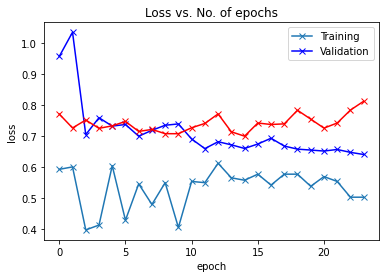

In [13]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [14]:
max([x['val_acc'] for x in history])

0.61328125

In [15]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [18]:
# get training set size to calculate # iterations and minibatch indices
train_size = train_x.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=2).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
        # Save checkpoint of the model
        checkpoint_filename = 'checkpoint/parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


cuda selected
Number of trainable params:  242098


In [19]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 500

# train it!
train(optimizer, model, num_epochs, train_x, train_y, val_x, val_y)

C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/2864264818.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, device=device).float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/2864264818.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)


Epoch 0: iteration 79/80

C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/2864264818.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid_tensor = torch.tensor(X_valid,device=device).float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/2864264818.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)



Epoch 0 --- loss:1.762, Epoch accuracy:55.08%, Validation loss:0.815, Validation accuracy:53.68%
Epoch 1: iteration 79/80
Epoch 1 --- loss:1.356, Epoch accuracy:56.83%, Validation loss:1.125, Validation accuracy:50.74%
Epoch 2: iteration 79/80
Epoch 2 --- loss:1.150, Epoch accuracy:58.19%, Validation loss:0.695, Validation accuracy:66.18%
Epoch 3: iteration 79/80
Epoch 3 --- loss:1.224, Epoch accuracy:60.37%, Validation loss:1.078, Validation accuracy:45.59%
Epoch 4: iteration 79/80
Epoch 4 --- loss:0.946, Epoch accuracy:62.59%, Validation loss:0.943, Validation accuracy:67.65%
Epoch 5: iteration 79/80
Epoch 5 --- loss:0.906, Epoch accuracy:65.67%, Validation loss:0.629, Validation accuracy:69.85%
Epoch 6: iteration 79/80
Epoch 6 --- loss:0.899, Epoch accuracy:63.02%, Validation loss:0.567, Validation accuracy:69.12%
Epoch 7: iteration 79/80
Epoch 7 --- loss:0.850, Epoch accuracy:66.13%, Validation loss:0.584, Validation accuracy:74.26%
Epoch 8: iteration 79/80
Epoch 8 --- loss:0.722,

Epoch 67: iteration 79/80
Epoch 67 --- loss:0.171, Epoch accuracy:92.72%, Validation loss:0.247, Validation accuracy:93.38%
Epoch 68: iteration 79/80
Epoch 68 --- loss:0.123, Epoch accuracy:94.90%, Validation loss:0.217, Validation accuracy:89.71%
Epoch 69: iteration 79/80
Epoch 69 --- loss:0.149, Epoch accuracy:93.54%, Validation loss:0.198, Validation accuracy:92.65%
Epoch 70: iteration 79/80
Epoch 70 --- loss:0.128, Epoch accuracy:94.51%, Validation loss:0.180, Validation accuracy:94.12%
Epoch 71: iteration 79/80
Epoch 71 --- loss:0.114, Epoch accuracy:95.45%, Validation loss:0.143, Validation accuracy:94.12%
Epoch 72: iteration 79/80
Epoch 72 --- loss:0.130, Epoch accuracy:94.82%, Validation loss:0.337, Validation accuracy:90.44%
Epoch 73: iteration 79/80
Epoch 73 --- loss:0.148, Epoch accuracy:94.01%, Validation loss:0.182, Validation accuracy:94.12%
Epoch 74: iteration 79/80
Epoch 74 --- loss:0.118, Epoch accuracy:95.13%, Validation loss:0.341, Validation accuracy:88.97%
Epoch 75

Epoch 133: iteration 79/80
Epoch 133 --- loss:0.051, Epoch accuracy:97.82%, Validation loss:0.138, Validation accuracy:94.85%
Epoch 134: iteration 79/80
Epoch 134 --- loss:0.063, Epoch accuracy:97.39%, Validation loss:0.192, Validation accuracy:94.12%
Epoch 135: iteration 79/80
Epoch 135 --- loss:0.124, Epoch accuracy:95.25%, Validation loss:0.238, Validation accuracy:93.38%
Epoch 136: iteration 79/80
Epoch 136 --- loss:0.066, Epoch accuracy:97.24%, Validation loss:0.283, Validation accuracy:91.91%
Epoch 137: iteration 79/80
Epoch 137 --- loss:0.071, Epoch accuracy:96.96%, Validation loss:0.264, Validation accuracy:91.91%
Epoch 138: iteration 79/80
Epoch 138 --- loss:0.047, Epoch accuracy:97.94%, Validation loss:0.226, Validation accuracy:95.59%
Epoch 139: iteration 79/80
Epoch 139 --- loss:0.059, Epoch accuracy:97.39%, Validation loss:0.145, Validation accuracy:94.85%
Epoch 140: iteration 79/80
Epoch 140 --- loss:0.047, Epoch accuracy:97.86%, Validation loss:0.358, Validation accuracy

Epoch 198: iteration 79/80
Epoch 198 --- loss:0.087, Epoch accuracy:96.30%, Validation loss:0.220, Validation accuracy:91.91%
Epoch 199: iteration 79/80
Epoch 199 --- loss:0.038, Epoch accuracy:98.44%, Validation loss:0.163, Validation accuracy:94.12%
Epoch 200: iteration 79/80
Epoch 200 --- loss:0.058, Epoch accuracy:97.43%, Validation loss:0.320, Validation accuracy:93.38%
Epoch 201: iteration 79/80
Epoch 201 --- loss:0.059, Epoch accuracy:97.59%, Validation loss:0.258, Validation accuracy:93.38%
Epoch 202: iteration 79/80
Epoch 202 --- loss:0.047, Epoch accuracy:98.33%, Validation loss:0.194, Validation accuracy:94.12%
Epoch 203: iteration 79/80
Epoch 203 --- loss:0.039, Epoch accuracy:98.33%, Validation loss:0.350, Validation accuracy:91.91%
Epoch 204: iteration 79/80
Epoch 204 --- loss:0.028, Epoch accuracy:98.48%, Validation loss:0.318, Validation accuracy:94.12%
Epoch 205: iteration 79/80
Epoch 205 --- loss:0.061, Epoch accuracy:97.20%, Validation loss:0.150, Validation accuracy

Epoch 263: iteration 79/80
Epoch 263 --- loss:0.035, Epoch accuracy:98.68%, Validation loss:0.168, Validation accuracy:96.32%
Epoch 264: iteration 79/80
Epoch 264 --- loss:0.088, Epoch accuracy:96.19%, Validation loss:0.342, Validation accuracy:93.38%
Epoch 265: iteration 79/80
Epoch 265 --- loss:0.064, Epoch accuracy:97.12%, Validation loss:0.353, Validation accuracy:90.44%
Epoch 266: iteration 79/80
Epoch 266 --- loss:0.061, Epoch accuracy:97.51%, Validation loss:0.223, Validation accuracy:92.65%
Epoch 267: iteration 79/80
Epoch 267 --- loss:0.076, Epoch accuracy:97.08%, Validation loss:0.208, Validation accuracy:91.91%
Epoch 268: iteration 79/80
Epoch 268 --- loss:0.031, Epoch accuracy:98.52%, Validation loss:0.247, Validation accuracy:92.65%
Epoch 269: iteration 79/80
Epoch 269 --- loss:0.024, Epoch accuracy:98.95%, Validation loss:0.247, Validation accuracy:91.18%
Epoch 270: iteration 79/80
Epoch 270 --- loss:0.027, Epoch accuracy:98.91%, Validation loss:0.177, Validation accuracy

Epoch 328: iteration 79/80
Epoch 328 --- loss:0.030, Epoch accuracy:98.83%, Validation loss:0.281, Validation accuracy:92.65%
Epoch 329: iteration 79/80
Epoch 329 --- loss:0.023, Epoch accuracy:98.95%, Validation loss:0.312, Validation accuracy:94.85%
Epoch 330: iteration 79/80
Epoch 330 --- loss:0.040, Epoch accuracy:98.09%, Validation loss:0.386, Validation accuracy:90.44%
Epoch 331: iteration 79/80
Epoch 331 --- loss:0.123, Epoch accuracy:95.10%, Validation loss:0.220, Validation accuracy:94.12%
Epoch 332: iteration 79/80
Epoch 332 --- loss:0.036, Epoch accuracy:98.29%, Validation loss:0.184, Validation accuracy:95.59%
Epoch 333: iteration 79/80
Epoch 333 --- loss:0.037, Epoch accuracy:98.17%, Validation loss:0.174, Validation accuracy:94.85%
Epoch 334: iteration 79/80
Epoch 334 --- loss:0.024, Epoch accuracy:98.79%, Validation loss:0.258, Validation accuracy:93.38%
Epoch 335: iteration 79/80
Epoch 335 --- loss:0.028, Epoch accuracy:98.52%, Validation loss:0.299, Validation accuracy

Epoch 393: iteration 79/80
Epoch 393 --- loss:0.080, Epoch accuracy:96.92%, Validation loss:0.268, Validation accuracy:94.12%
Epoch 394: iteration 79/80
Epoch 394 --- loss:0.038, Epoch accuracy:98.17%, Validation loss:0.317, Validation accuracy:91.91%
Epoch 395: iteration 79/80
Epoch 395 --- loss:0.075, Epoch accuracy:96.89%, Validation loss:0.294, Validation accuracy:94.12%
Epoch 396: iteration 79/80
Epoch 396 --- loss:0.044, Epoch accuracy:98.09%, Validation loss:0.327, Validation accuracy:91.18%
Epoch 397: iteration 79/80
Epoch 397 --- loss:0.045, Epoch accuracy:97.94%, Validation loss:0.419, Validation accuracy:90.44%
Epoch 398: iteration 79/80
Epoch 398 --- loss:0.053, Epoch accuracy:97.24%, Validation loss:0.339, Validation accuracy:94.12%
Epoch 399: iteration 79/80
Epoch 399 --- loss:0.041, Epoch accuracy:98.37%, Validation loss:0.266, Validation accuracy:92.65%
Epoch 400: iteration 79/80
Epoch 400 --- loss:0.041, Epoch accuracy:98.01%, Validation loss:0.225, Validation accuracy

Epoch 458: iteration 79/80
Epoch 458 --- loss:0.045, Epoch accuracy:97.74%, Validation loss:0.362, Validation accuracy:93.38%
Epoch 459: iteration 79/80
Epoch 459 --- loss:0.074, Epoch accuracy:96.65%, Validation loss:0.286, Validation accuracy:91.91%
Epoch 460: iteration 79/80
Epoch 460 --- loss:0.027, Epoch accuracy:98.64%, Validation loss:0.217, Validation accuracy:93.38%
Epoch 461: iteration 79/80
Epoch 461 --- loss:0.048, Epoch accuracy:97.78%, Validation loss:0.290, Validation accuracy:91.91%
Epoch 462: iteration 79/80
Epoch 462 --- loss:0.061, Epoch accuracy:97.63%, Validation loss:0.296, Validation accuracy:92.65%
Epoch 463: iteration 79/80
Epoch 463 --- loss:0.052, Epoch accuracy:97.70%, Validation loss:0.227, Validation accuracy:94.12%
Epoch 464: iteration 79/80
Epoch 464 --- loss:0.026, Epoch accuracy:98.87%, Validation loss:0.257, Validation accuracy:93.38%
Epoch 465: iteration 79/80
Epoch 465 --- loss:0.017, Epoch accuracy:98.95%, Validation loss:0.277, Validation accuracy

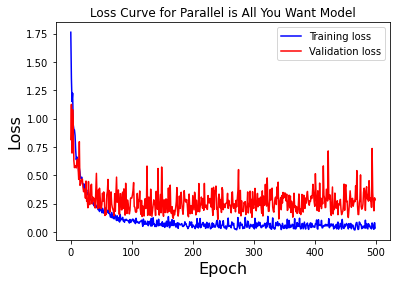

In [20]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [37]:
import os
# pick load folder  
load_folder = 'checkpoint'  

# pick the epoch to load
epoch = '471'
model_name = f'parallel_all_you_wantFINAL-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary 
model = parallel_all_you_want(2)
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoint\parallel_all_you_wantFINAL-471.pkl


In [42]:
validate = make_validate_fnc(model,criterion)

X_val = val_x
y_val = val_y
# Convert 4D test feature set array to tensor and move to GPU
X_val_tensor = torch.tensor(X_val,device='cpu').float()
# Convert 4D test label set array to tensor and move to GPU
y_val_tensor = torch.tensor(y_val,dtype=torch.long,device='cpu')

# Get the model's performance metrics using the validation function we defined
_loss, _acc, predicted_emotions = validate(X_val_tensor,y_val_tensor)

print(f'Validation accuracy is {_acc:.2f}%')

C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/2725604674.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val,device='cpu').float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/2725604674.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val,dtype=torch.long,device='cpu')


Validation accuracy is 96.32%


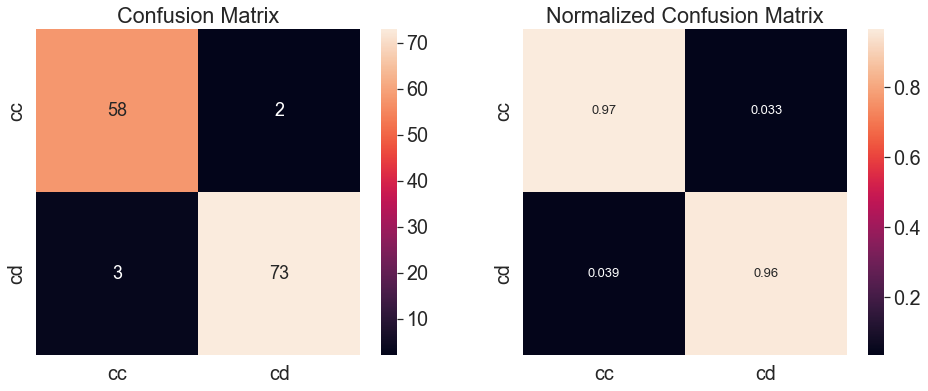

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions
# use labels from test set
emotions_groundtruth = y_val

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = ['cc', 'cd']

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

ToDo: Make X_Test and Y_Test, Confusion Matrix, 

In [49]:
import os
# pick load folder  
load_folder = 'checkpoint'  

# pick the epoch to load
epoch = '210'
model_name = f'parallel_all_you_wantFINAL-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary 
model = parallel_all_you_want(2)
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoint\parallel_all_you_wantFINAL-210.pkl


In [50]:
data_path = 'adress_test.pkl'

X_test,Y_test,_X,_Y = load_data(data_path)
# converting training images into torch format
X_test  = torch.from_numpy(X_test)

# converting the target into torch format

Y_test = Y_test.reshape(Y_test.shape[0]).astype(float);
y_test = torch.from_numpy(Y_test)

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test,device='cpu').float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device='cpu')

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/753559069.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test,device='cpu').float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_15788/753559069.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test,dtype=torch.long,device='cpu')


Test accuracy is 59.29%


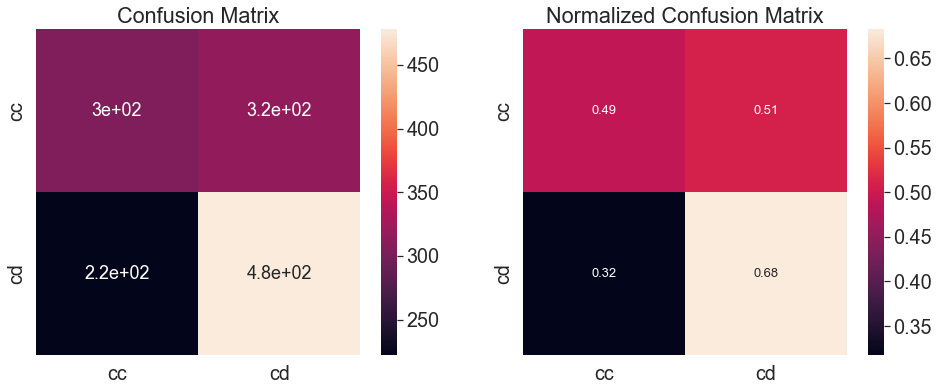

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = ['cc', 'cd']

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()